In [1]:
#SOURCES

#http://cshprotocols.cshlp.org/content/2015/4/pdb.top086124.long
#https://scipy-cookbook.readthedocs.io/items/FittingData.html

In [2]:
#IMPORTING DEPENDENCIES

import cv2
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

from astropy.modeling import models, fitting
import warnings

import matplotlib.cm as cm
import sklearn.preprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage

from skimage.draw import line
from skimage.draw import line_aa

In [3]:
#FUNCTIONS

def crop_center(img,cropx,cropy):
    """Crop a centered rectangle or square"""
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

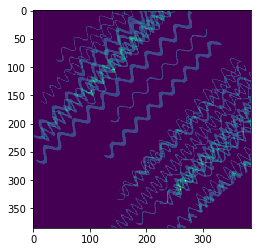

In [4]:
npixels=384
simfibimg=np.ones((npixels+1,npixels+1))

#M = cv2.getRotationMatrix2D((cols/2,rows/2),rotangle,1)

xaxis=np.linspace(0,npixels,npixels+1)
yaxis=np.linspace(0,npixels,npixels+1)

xaxis,yaxis=np.meshgrid(xaxis,yaxis)

numfibers=30
minthickness=1
maxthickness=5

for i in range(1,numfibers):
    simfibimgearly=np.zeros((npixels+1,npixels+1))
    x_start=np.random.randint(0,npixels/2)
    y_start=np.random.randint(0,npixels)
    #x_start=0
    #y_start=npixels/2
    rotangle=np.random.randint(40,50)
    #rotangle=45
    #length=np.random.randint(npixels/2,npixels)
    length=npixels
    amplitude=np.random.randint(npixels/50,npixels/30)
    #amplitude=npixels/20
    period=np.random.randint(npixels/30,npixels/10)
    #period=npixels/5
    thickness=np.random.randint(minthickness,maxthickness)
    #thickness=1
    fiber_x=np.linspace(x_start,x_start+length,npixels*5000)
    fiber_y=y_start+amplitude*np.sin((fiber_x-x_start)/period*2*np.pi)

    for j in range(1,thickness):
        fiber_x=np.append(fiber_x,fiber_x)
        fiber_y=np.append(fiber_y,fiber_y+j)

    goodpositions=np.where(np.logical_and(np.logical_and(fiber_x<=npixels,fiber_y<=npixels),np.logical_and(fiber_x>=0,fiber_y>=0)))[0]

    fiber_x=fiber_x[goodpositions]
    fiber_y=fiber_y[goodpositions]

    fiber_x=np.round(fiber_x).astype(int)
    fiber_y=np.round(fiber_y).astype(int)
    
    # THIS IS WHERE I ROTATE THE SINUSOIDS
    # adjusted_x = (fiber_x - x_start)
    # adjusted_y = (fiber_y - y_start)
    # cos_rad = np.cos(rotangle*np.pi/180)
    # sin_rad = np.sin(rotangle*np.pi/180)
    # fiber_x = x_start + cos_rad * adjusted_x + sin_rad * adjusted_y
    # fiber_y = y_start + -sin_rad * adjusted_x + cos_rad * adjusted_y
    
    for x,y in zip(fiber_x,fiber_y):
        simfibimgearly[y,x]=1000
    
    M = cv2.getRotationMatrix2D((npixels/2,npixels/2),rotangle,1)
    
    simfiber=cv2.warpAffine(simfibimgearly,M,(npixels+1,npixels+1))
    
    simfibimg=simfibimg+simfiber

  #  simfibimg[int(y-1),int(x)]=100
  #  simfibimg[int(y+1),int(x)]=100

#for x in xaxis:
#    for y in yaxis:
#        simfibimg[x][y]=np.sin(x)
        
#plt.plot(xaxis,yaxis)
#plt.imshow(simfibimg,cmap='viridis')
#plt.plot(fiber_x*10,fiber_y*10,'.',c='g')
#plt.plot(x_start,y_start,'o',c='r')
plt.imshow(simfibimg)
plt.show()


#image_rescaled.shape

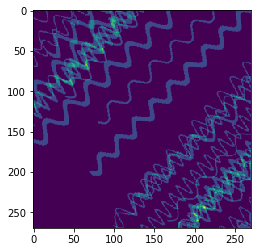

In [5]:
cropsimfibimg=crop_center(simfibimg,270,270)
plt.imshow(cropsimfibimg)
plt.show()

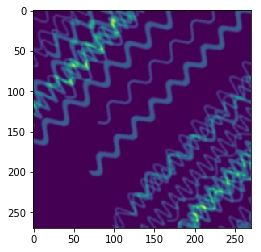

In [6]:
gausskern=cv2.GaussianBlur(cropsimfibimg,(5,5),0)
plt.imshow(gausskern)
plt.show()

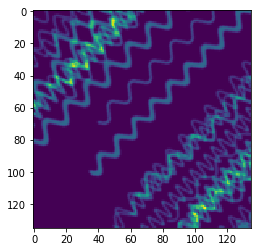

In [7]:
image=gausskern*1
image_rescaled = rescale(image, 1.0 / 2.0,mode='constant')
plt.imshow(image_rescaled)
plt.show()
#image=gausskern*1
#image_rescaled = rescale(image, 1.0 / 2.0,mode='constant',anti_aliasing=True)
#plt.imshow(image_rescaled)
#plt.show()


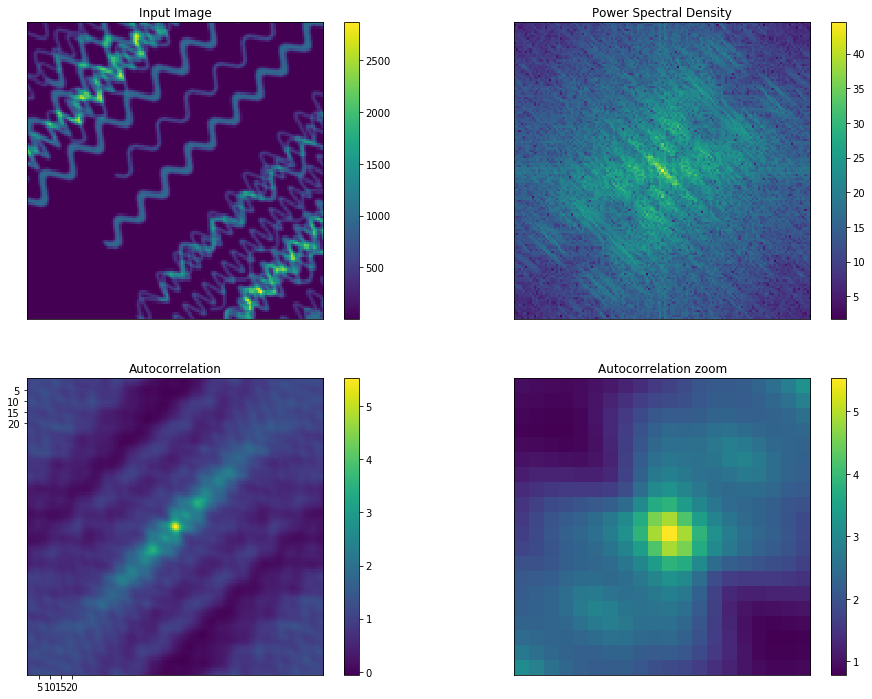

In [8]:
#AUTOCORRELATION

#imgforft=gausskern*1
#imgforft=simfibimg*1
imgforft=image_rescaled*1
#plotcorr=np.real(np.fft.fft2(imgforft))

#dft = cv2.dft(np.float32(imgforft),flags = cv2.DFT_COMPLEX_OUTPUT)
#dft_shift = np.fft.fftshift(dft)

myft=(np.log10(abs(np.fft.fftshift(np.fft.fft2(imgforft)))))**2
    
plotcorr=(np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(imgforft)*np.conjugate(np.fft.fft2(imgforft)))))/((np.mean(imgforft)*np.mean(imgforft)*100*100 )))-1

plotcorrzoom=crop_center(plotcorr,20,20)

#magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
#powerspectraldensity = magnitude_spectrum**2
plt.figure(figsize=(16,12))
plt.subplot(221),plt.imshow(imgforft)
plt.colorbar()
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(myft)
plt.colorbar()
plt.title('Power Spectral Density'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(plotcorr)
plt.colorbar()
plt.title('Autocorrelation'), plt.xticks([5,10,15,20]), plt.yticks([5,10,15,20])
plt.subplot(224),plt.imshow(plotcorrzoom)
plt.colorbar()
plt.title('Autocorrelation zoom'), plt.xticks([]), plt.yticks([])
plt.show()


In [9]:
density=1/(plotcorr[50,50])
#(density,plotcorr[12,12])
density


2.351423175773037

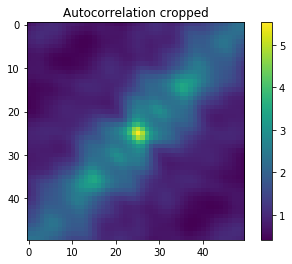

In [10]:
#newimg=crop_center(plotcorr,100,200)*1
newimg=crop_center(plotcorr,50,50)
plt.imshow(newimg)
plt.colorbar()
plt.title('Autocorrelation cropped')
plt.show()

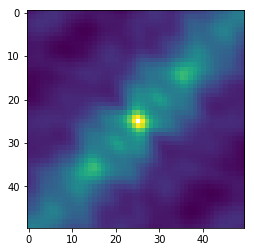

In [11]:
#FITTING 2D GAUSSIAN WITH ROTATION
#newimgmask=newimg*1
mat=newimg*1
#newimg2=newimgmask*1
#averagevalue=(newimg2[4,4]+newimg2[4,5]+newimg2[4,6])/3
#newimg2[5,5]=averagevalue
rows, cols = mat.shape
xv, yv = np.meshgrid(range(cols), range(rows)[::-1])


#ignore max point when f
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(newimg)
newimgmask=newimg*1
newimgmask[max_loc]=np.nan

#newimgmask[max_loc]=0
plt.imshow(newimgmask)
plt.show()

mask1=np.ma.masked_invalid(newimgmask)

/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:456: RuntimeWarning: divide by zero encountered in true_divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:457: RuntimeWarning: divide by zero encountered in true_divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:458: RuntimeWarning: divide by zero encountered in true_divide
  c = 0.5 * ((sint2 / xstd2) + (cost2 / ystd2))
/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:459: RuntimeWarning: invalid value encountered in add
  return amplitude * np.exp(-((a * xdiff ** 2) + (b * xdiff * ydiff) +


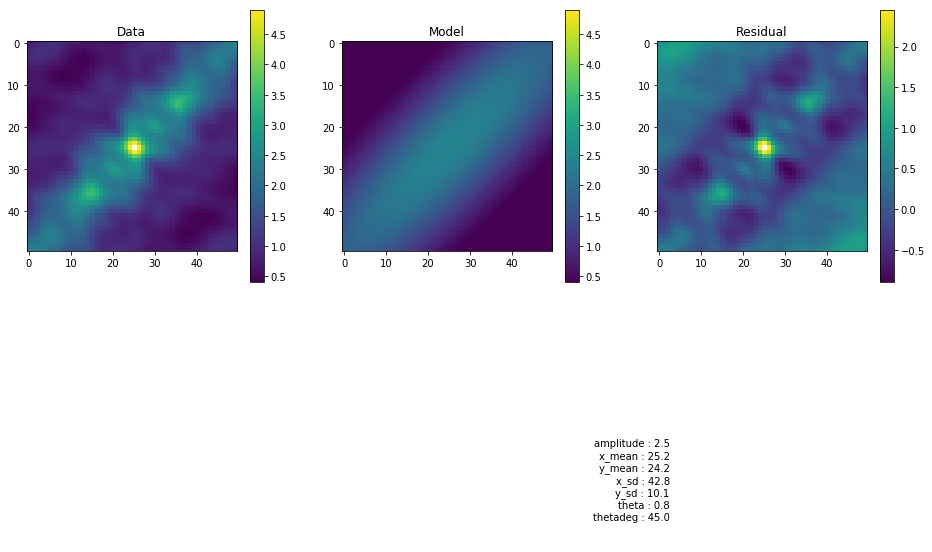

In [12]:
import scipy.optimize

def scipyFunc(parameters, xv,yv, image):
    amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=parameters
    p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)
    return np.nanmean((image-p(xv,yv))**2)


cols,rows=mask1.shape

fitted=scipy.optimize.minimize(scipyFunc,(2,cols/2,rows/2,1,1,0),(xv,yv,mask1),bounds=((np.nanmin(mask1),10*np.nanmax(mask1)),(None,None),(None,None),(0,cols),(0,rows),(0,np.pi/4))).x

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=fitted
p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)


# Plot the data with the best-fit model
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask1, interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(p(xv, yv), interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Model")
ax = plt.gca()
thetadeg=p.theta.value*180/np.pi
plt.text(1.56, -1.4, """
amplitude : %.1f
x_mean : %.1f
y_mean : %.1f
x_sd : %.1f
y_sd : %.1f
theta : %.1f
thetadeg : %.1f

""" %(amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,thetadeg),
        fontsize=10, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(mask1 - p(xv, yv), interpolation='nearest')
plt.title("Residual")
plt.colorbar()
plt.show()


In [13]:
scipyFunc(fitted,xv,yv, mask1)

0.16246195936424332

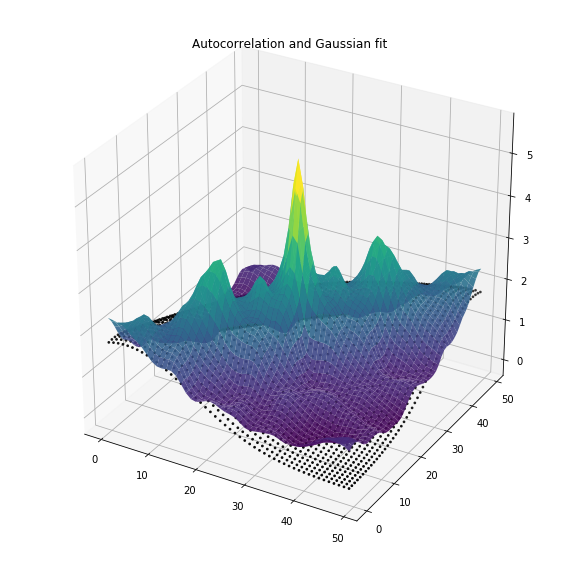

In [14]:

fig=plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(xv, yv, p(xv,yv), c='black', s=3)
ax.plot_surface(xv, yv, newimg, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.9)

ax.set_title('Autocorrelation and Gaussian fit');
plt.show()